In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-xray-dataset-train-test-sets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F561588%2F1020806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T064910Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2223276b93506e9c048a892e5606c448fec27fb10685251dd6ec9a5fa46682e5991514d95c5f13c01244fb0144df8171082610282ebfb6b7a915892b38157f4163ec08c2e2845c936fc9c476a45ac109c3f00ad4e5839a71c3c0f91a3e324ee8185e3476cb620897dc9d46d1b9508539a45896c5e8d9a380edfc72322ea2059acb760552acaa5b647b5426e8b1eae0fcde7a4d54d3c07e08b2fb92c7428ebb10e494e9bfcd9b475d54be2d25f1be45341288d002511f9ecd3793eace925f01257c6359e7c958f73b2ebcac6b111656cc56fd04bfeb24cd0afe329b05423756fe6f13c73d24cf9316f4e85d962ad2c03958d9959b9a08be1f04815e714acac7c9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 88399353 bytes downloaded
Downloaded and uncompressed: covid19-xray-dataset-train-test-sets
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D

In [ ]:
data_train_path = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train'
data_test_path = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test'
img_h=180
img_w=180
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_w,img_h),
    subset="training",
    validation_split=0.2,
    seed=47 )
data_val = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    validation_split=0.2,
    subset="validation",
    image_size=(img_w,img_h),
    shuffle=True,
    seed=47 )
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=False,
    image_size=(img_w,img_h) )

Found 148 files belonging to 2 classes.
Using 119 files for training.
Found 148 files belonging to 2 classes.
Using 29 files for validation.
Found 40 files belonging to 2 classes.


In [ ]:
class_names=data_val.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
import numpy as np
for i,j in data_train.take(1):
  print(i)

tf.Tensor(
[[[[6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   ...
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]]

  [[6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   ...
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]]

  [[6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   ...
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]]

  ...

  [[6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6

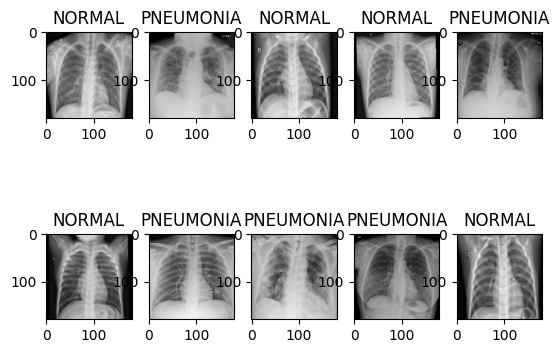

In [ ]:
plt.figsize=(10,10)
for a,b in data_val.take(1):
  for i in range(10):
      plt.subplot(2,5,i+1)
      plt.imshow(a[i].numpy().astype('uint8'))
      plt.title(class_names[b[i]])
      # plt.axis('off')

In [ ]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_h,img_w,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(layers.Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(data_train,epochs=10,validation_data=(data_val))

Epoch 1/10
4/4 [==============================] - 14s 3s/step - loss: 793.7281 - accuracy: 0.5042 - val_loss: 34.5761 - val_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 12s 3s/step - loss: 16.5573 - accuracy: 0.4790 - val_loss: 2.3944 - val_accuracy: 0.4828
Epoch 3/10
4/4 [==============================] - 10s 2s/step - loss: 1.4398 - accuracy: 0.5798 - val_loss: 1.1722 - val_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 11s 2s/step - loss: 0.7582 - accuracy: 0.6639 - val_loss: 0.1744 - val_accuracy: 0.9310
Epoch 5/10
4/4 [==============================] - 11s 2s/step - loss: 0.3058 - accuracy: 0.8739 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 12s 3s/step - loss: 0.1562 - accuracy: 0.9580 - val_loss: 0.1135 - val_accuracy: 0.9655
Epoch 7/10
4/4 [==============================] - 10s 2s/step - loss: 0.1030 - accuracy: 0.9832 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 8/10
4/4 [==============

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

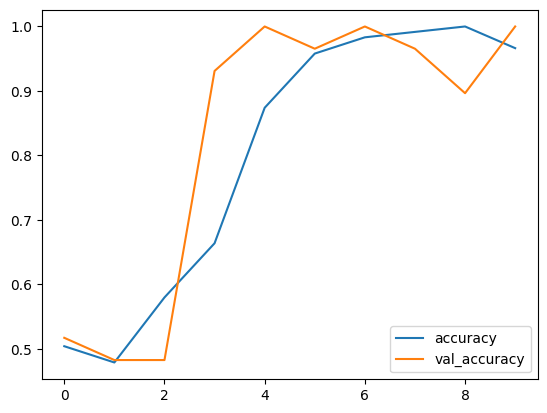

In [ ]:
plt.figsize=(10,10)
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(data_test)

2/2 [==============================] - 3s 128ms/step - loss: 0.0430 - accuracy: 1.0000


[0.04300995543599129, 1.0]

In [ ]:
input_shape=(128,128,3)
resnet_model=Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                              input_shape=input_shape,
                                              pooling='max',classes=2,
                                              weights='imagenet')
for layer in pretrained_model.layers:
    layers.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(Dense(1,activation='sigmoid'))
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 24,584,193 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)